In [4]:
%config Completer.use_jedi = False

#___________________________________________________________________________________________________________________
get_ipython().magic('matplotlib notebook')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')


import matplotlib.pyplot as plt
import sys
import os
import xarray as xr
from matplotlib.tri import Triangulation
import pandas as pa

sys.path.append("./src/")
from sub_mesh        import * 
from sub_utility     import * 
from sub_plot        import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load mesh: 

In [5]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
meshpath='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh=load_mesh_fesom2(meshpath, do_rot='None', focus=0, do_info=True, do_pickle=False, do_lsmask=False, do_augmpbnd=False)

 > load mesh from *.out files: /work/ollie/projects/clidyn/FESOM2/meshes/core2
___FESOM2 MESH INFO________________________
 > path            = /work/ollie/projects/clidyn/FESOM2/meshes/core2
 > id              = core2
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = False
 > do cavity       = False
 > do lsmask       = False
 > do earea,eresol = False, False
 > do narea,nresol = False, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


### Load topo data + linear interpolation:

In [21]:
do_on_elem = True
vname      = 'topo'
topofile   = 'global_gebco_ibcao_1min_topo.nc'
topodir    = '/work/ollie/pscholz/orig_core2_topo/'

if do_on_elem: savedir = '/work/ollie/pscholz/mesh_fesom2.0/core2_dep@elem/'
else:          savedir = '/work/ollie/pscholz/mesh_fesom2.0/core2_dep@node/'

# load topo data
topopath = os.path.join(topodir,topofile)
data = xr.open_dataset(topopath)
data=data.assign_coords(DimLon=data.lon[:,0])
data=data.assign_coords(DimLat=data.lat[:,1])
print('reg_x min, max = {}, {}'.format(str(data.DimLon.data.min()), str(data.DimLon.data.max())))
print('reg_y min, max = {}, {}'.format(str(data.DimLat.data.min()), str(data.DimLat.data.max())))

# kick out gradient of topo from dataset
list_vname=list(data.keys())
list_vname.remove(vname)
data = data.drop(labels=list_vname)

# eliminate land points --> set to 0.0
data = data.where(data<0, other=0.0)

# do linear interpolation, 1st define points for interpolation 
# add fesom2 mesh coordinatesro xarray dataset
if do_on_elem: 
    e_x  = xr.DataArray(mesh.n_x[mesh.e_i].sum(axis=1)/3.0, dims="e2dn")
    e_y  = xr.DataArray(mesh.n_y[mesh.e_i].sum(axis=1)/3.0, dims="e2dn")
    data = data.interp(DimLon=e_x, DimLat=e_y, method='linear')
    
    print('e_x min, max = {}, {}'.format(str(np.min(mesh.n_x[mesh.e_i].sum(axis=1)/3.)), str(np.max(mesh.n_x[mesh.e_i].sum(axis=1)/3.))))
    print('e_y min, max = {}, {}'.format(str(np.min(mesh.n_y[mesh.e_i].sum(axis=1)/3.)), str(np.min(mesh.n_y[mesh.e_i].sum(axis=1)/3.))))
else: 
    n_x  = xr.DataArray(mesh.n_x, dims="n2dn")
    n_y  = xr.DataArray(mesh.n_y, dims="n2dn")
    data = data.interp(DimLon=n_x, DimLat=n_y, method='linear')

    print('n_x min, max = {}, {}'.format(str(mesh.n_x.min()), str(mesh.n_x.max())))
    print('n_y min, max = {}, {}'.format(str(mesh.n_y.min()), str(mesh.n_y.max())))
    
# make sure ocean depths are negative    
data = -abs(data)    

print(data)


reg_x min, max = -180.0, 180.0
reg_y min, max = -90.0, 90.0
e_x min, max = -179.86055, 179.88007
e_y min, max = -78.44974, -78.44974
<xarray.Dataset>
Dimensions:  (e2dn: 244659)
Coordinates:
    DimLat   (e2dn) float32 -76.89721 -72.86144 -75.523 ... 25.178766 24.268301
    DimLon   (e2dn) float32 -153.77097 -45.988434 ... -78.0773 -78.6462
Dimensions without coordinates: e2dn
Data variables:
    topo     (e2dn) float64 -703.9 -642.6 -91.25 -4.558e+03 ... -1.0 -1.926 -1.0


### Compute smooth topo:

In [22]:
#_________________________________________________________________________________________
# set topo smoothing parameter
special_region = True
special_boxlist= list()
special_boxlist.append([-180.0, -158.0, 63.0, 80.0]) # !!! check special box condition !!!
special_boxlist.append([ 178.0,  180.0, 63.0, 80.0]) # !!! check special box condition !!!
#special_boxlist.append([  -6.0,   -2.5, 34.5, 37.5])
# special_boxlist.append([  -158.0,   178, 63.0, 80.0])

rel_cent_weight= 2.0 # >=1
num_iter       = 2

set_min_dep    = True
min_depth      = -10.0
set_max_dep    = True
max_depth      = -6000.0

#_____________________________________________________________________________________________
# set min/max water depth
if set_min_dep: data = data.where(data<=-np.abs(min_depth), other=-np.abs(min_depth))
if set_max_dep: data = data.where(data>=-np.abs(max_depth), other=-np.abs(max_depth))
zmin, zmax = data[vname].data.min(), data[vname].data.max()
if set_max_dep or set_min_dep: print(' --> after applying min/max depth limitation')
print(' --> min, max depth: {}, {}'.format(str(zmin), str(zmax)))    
data_orig = data[vname].data.copy()


#_____________________________________________________________________________________________
# save orig depth (without smoothing, but with min/max depth adaption)
if savedir is not None:
    if do_on_elem : savefile = 'depth_elem_orig.out'
    else:           savefile = 'depth_node_orig.out'    
    print(' --> save original topo @:{}'.format(str(os.path.join(savedir,savefile))))
    if not os.path.isdir(savedir): os.makedirs(savedir)
    fid = pa.DataFrame(data_orig)
    fid.to_csv(os.path.join(savedir,savefile), index=False, header=False, float_format='%.2f')

#_____________________________________________________________________________________________
# compute smoothing either on nodes or element
if not do_on_elem:
    # compute node neighbourhood
    n_nghbr_n   = do_node_neighbour(mesh)

    # compute smoothing
    data_smooth = do_node_smoothing(mesh, data_orig, n_nghbr_n, 
                                    special_region, special_boxlist, rel_cent_weight, num_iter)

else: 
    # compute elem neighbourhood
    e_nghbr_e   = do_elem_neighbour(mesh)
    
    # compute smoothing
    data_smooth = do_elem_smoothing(mesh, data_orig, e_nghbr_e, 
                                    special_region, special_boxlist, rel_cent_weight, num_iter)
    
#_____________________________________________________________________________________________
# save smoothed depth
if savedir is not None:
    if do_on_elem : savefile = 'depth_elem_smooth.out'
    else:           savefile = 'depth_node_smooth.out'    
    print(' --> save smoothed topo @:{}'.format(str(os.path.join(savedir,savefile))))
    if not os.path.isdir(savedir): os.makedirs(savedir)
    fid = pa.DataFrame(data_smooth)
    fid.to_csv(os.path.join(savedir,savefile), index=False, header=False, float_format='%.2f')

 --> after applying min/max depth limitation
 --> min, max depth: -6000.0, -10.0
 --> save original topo @:/work/ollie/pscholz/mesh_fesom2.0/core2_dep@elem/depth_elem_orig.out
 --> compute node neighbourhood
 --> compute edge neighbourhood
 --> compute elem neighbourhood
 --> compute elem smoothing
     iter: 0
     iter: 1
 --> save smoothed topo @:/work/ollie/pscholz/mesh_fesom2.0/core2_dep@elem/depth_elem_smooth.out


### Plot topo:

<IPython.core.display.Javascript object>


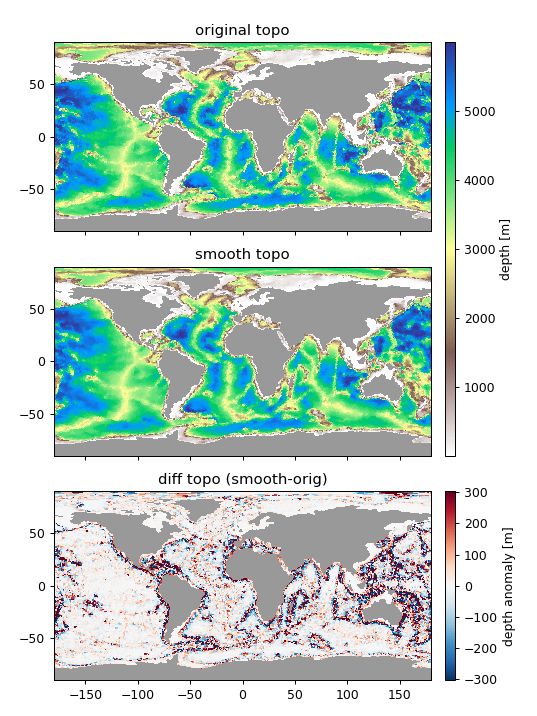

In [8]:
tri = Triangulation(mesh.n_x, mesh.n_y, mesh.e_i[mesh.e_pbnd_0,:])
fig, ax = plt.subplots(3, 1, figsize=[6,8], sharex=True, sharey=True)
fig.tight_layout()

#_____________________________________________________________________________________________
if do_on_elem: data_plot = np.abs(data_orig[mesh.e_pbnd_0])
else:          data_plot = np.abs(data_orig)
hp1=ax[0].tripcolor(tri,data_plot, cmap='terrain_r')
ax[0].set_title('original topo')

#_____________________________________________________________________________________________
if do_on_elem: data_plot = np.abs(data_smooth[mesh.e_pbnd_0])
else:          data_plot = np.abs(data_smooth)
hp1=ax[1].tripcolor(tri,data_plot, cmap='terrain_r')
ax[1].set_title('smooth topo')

#_____________________________________________________________________________________________
if do_on_elem: data_plot = np.abs(data_smooth[mesh.e_pbnd_0])-np.abs(data_orig[mesh.e_pbnd_0])
else:          data_plot = np.abs(data_smooth)-np.abs(data_orig)
cfac = 0.1
cmin, cmax = data_plot.min(), data_plot.max()
cmax       = np.max([np.abs(cmin),cmax])
cmin       = -cmax
hp2=ax[2].tripcolor(tri,data_plot, vmin=cmin*cfac, vmax=cmax*cfac, cmap='RdBu_r')
ax[2].set_title('diff topo (smooth-orig)')

#_____________________________________________________________________________________________
for axi in ax:
    axi.set_facecolor([0.6 ,0.6,0.6])
    axi.set_xlim(-180,180)
    axi.set_ylim(-90,90)
    axi.set_aspect('equal')

#_____________________________________________________________________________________________
cbar1 = plt.colorbar(hp1, ax=ax[:2], label='depth [m]')
cbar2 = plt.colorbar(hp2, ax=ax[2] , label='depth anomaly [m]')

#_____________________________________________________________________________________________
nax = len(ax)
ax_pos = np.zeros((nax,4))
for jj in range(0,nax):
    aux = ax[jj].get_position()
    ax_pos[jj,:] = np.array([aux.x0, aux.y0, aux.width, aux.height])

x0, y0, x1, y1 = 0.1, 0.05, 0.9, 0.9
w,  h  = ax_pos[:,2].min(), ax_pos[:,3].min()
wg, hg = 0.025, 0.05

ax[0].set_position( [x0+(w+wg)*0, y0+(h+hg)*2, w, h] )
ax[1].set_position( [x0+(w+wg)*0, y0+(h+hg)*1, w, h] )
ax[2].set_position( [x0+(w+wg)*0, y0+(h+hg)*0, w, h] )
    
cbar2_pos = cbar2.ax.get_position()
cbar2.ax.set_position([x0+(w+wg)*1, y0, cbar2_pos.width*1.0, h])
cbar2.ax.set_aspect('auto')

cbar1_pos = cbar1.ax.get_position()
cbar1.ax.set_position([x0+(w+wg)*1, y0+h+hg, cbar2_pos.width*1.0, h*2+hg])
cbar1.ax.set_aspect('auto')

plt.show(block=False)

### Compare different bottom topographies #1:

depth1 min, max depth: 20.0, 6000.0
depth2 min, max depth: 10.0, 5991.846764502382


<IPython.core.display.Javascript object>


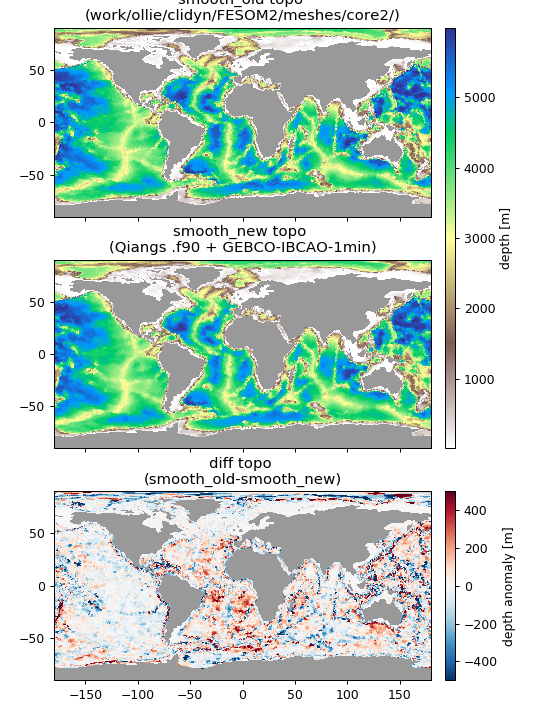

-2100.1415171629683 2654.133921662162


In [9]:
ndname1='/work/ollie/clidyn/FESOM2/meshes/core2/aux3d.out'
with open(ndname1) as f:
    nlev= int(next(f))
    zlev= np.array([next(f).rstrip() for x in range(nlev)]).astype(float)
    depth1 = np.array([next(f).rstrip() for x in range(mesh.n2dn)]).astype(float)
    depth1 = np.abs(depth1)
print('depth1 min, max depth: {}, {}'.format(str(depth1.min()), str(depth1.max())))    
    
ndname2='/work/ollie/pscholz/mesh_fesom2.0/core2_dep@elem/depth_node_smooth.out'
# ndname2='/work/ollie/pscholz/mesh_fesom2.0/core2_dep@elem/depth_node_orig.out'
with open(ndname2) as f:
    depth2 = np.array([next(f).rstrip() for x in range(mesh.n2dn)]).astype(float)
    depth2 = np.abs(depth2)    
print('depth2 min, max depth: {}, {}'.format(str(depth2.min()), str(depth2.max())))    

depth12 = depth1-depth2

#_____________________________________________________________________________________________
tri = Triangulation(mesh.n_x, mesh.n_y, mesh.e_i[mesh.e_pbnd_0,:])
fig, ax = plt.subplots(3, 1, figsize=[6,8], sharex=True, sharey=True)
fig.tight_layout()

#_____________________________________________________________________________________________
data_plot = depth1
hp1=ax[0].tripcolor(tri,data_plot, cmap='terrain_r')
ax[0].set_title('smooth_old topo \n(work/ollie/clidyn/FESOM2/meshes/core2/)')

#_____________________________________________________________________________________________
data_plot = depth2
hp1=ax[1].tripcolor(tri,data_plot, cmap='terrain_r')
ax[1].set_title('smooth_new topo \n(Qiangs .f90 + GEBCO-IBCAO-1min)')

#_____________________________________________________________________________________________
data_plot = depth1-depth2
cfac = 1.0
cmin, cmax = data_plot.min(), data_plot.max()
print(cmin, cmax)
cmax       = np.max([np.abs(cmin),cmax])
cmin       = -cmax
cmin, cmax = -500, 500
hp2=ax[2].tripcolor(tri,data_plot, vmin=cmin*cfac, vmax=cmax*cfac, cmap='RdBu_r')
ax[2].set_title('diff topo \n(smooth_old-smooth_new)')

#_____________________________________________________________________________________________
for axi in ax:
    axi.set_facecolor([0.6 ,0.6,0.6])
    axi.set_xlim(-180,180)
    axi.set_ylim(-90,90)
    axi.set_aspect('equal')

#_____________________________________________________________________________________________
cbar1 = plt.colorbar(hp1, ax=ax[:2], label='depth [m]')
cbar2 = plt.colorbar(hp2, ax=ax[2] , label='depth anomaly [m]')

#_____________________________________________________________________________________________
nax = len(ax)
ax_pos = np.zeros((nax,4))
for jj in range(0,nax):
    aux = ax[jj].get_position()
    ax_pos[jj,:] = np.array([aux.x0, aux.y0, aux.width, aux.height])

x0, y0, x1, y1 = 0.1, 0.05, 0.9, 0.9
w,  h  = ax_pos[:,2].min(), ax_pos[:,3].min()
wg, hg = 0.025, 0.06

ax[0].set_position( [x0+(w+wg)*0, y0+(h+hg)*2, w, h] )
ax[1].set_position( [x0+(w+wg)*0, y0+(h+hg)*1, w, h] )
ax[2].set_position( [x0+(w+wg)*0, y0+(h+hg)*0, w, h] )
    
cbar2_pos = cbar2.ax.get_position()
cbar2.ax.set_position([x0+(w+wg)*1, y0, cbar2_pos.width*1.0, h])
cbar2.ax.set_aspect('auto')

cbar1_pos = cbar1.ax.get_position()
cbar1.ax.set_position([x0+(w+wg)*1, y0+h+hg, cbar2_pos.width*1.0, h*2+hg])
cbar1.ax.set_aspect('auto')

do_save = None #'/home/ollie/pscholz/figures/test_dep@elem/topo_old_new_@node.png'
do_savefigure(do_save, dpi=300, transparent=False, facecolor=None)

plt.show(block=False)

### Compare different bottom topographies #2:

depth1 min, max depth: 20.0, 6000.0
depth2 min, max depth: 10.0, 5991.846764502382
depth3 min, max depth: 20.0, 5994.0


<IPython.core.display.Javascript object>


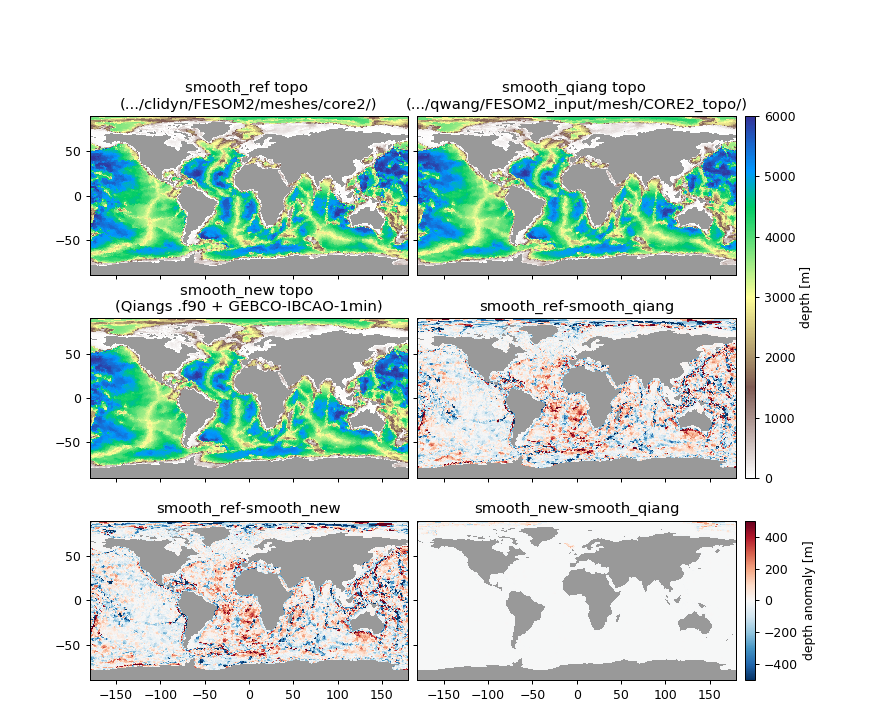

-2100.1415171629683 2654.133921662162
 > save figure: /home/ollie/pscholz/figures/test_dep@elem/topo_ref_new_qiang@node.png


In [10]:
ndname1='/work/ollie/clidyn/FESOM2/meshes/core2/aux3d.out'
with open(ndname1) as f:
    nlev= int(next(f))
    zlev= np.array([next(f).rstrip() for x in range(nlev)]).astype(float)
    depth1 = np.array([next(f).rstrip() for x in range(mesh.n2dn)]).astype(float)
    depth1 = np.abs(depth1)
print('depth1 min, max depth: {}, {}'.format(str(depth1.min()), str(depth1.max())))    
    
ndname2='/work/ollie/pscholz/mesh_fesom2.0/core2_dep@elem/depth_node_smooth.out'
with open(ndname2) as f:
    depth2 = np.array([next(f).rstrip() for x in range(mesh.n2dn)]).astype(float)
    depth2 = np.abs(depth2)
print('depth2 min, max depth: {}, {}'.format(str(depth2.min()), str(depth2.max())))    

ndname3='/work/ollie/qwang/FESOM2_input/mesh/CORE2_topo/aux3d.out'
with open(ndname3) as f:
    nlev= int(next(f))
    zlev= np.array([next(f).rstrip() for x in range(nlev)]).astype(float)
    depth3 = np.array([next(f).rstrip() for x in range(mesh.n2dn)]).astype(float)
    depth3 = np.abs(depth3)  
print('depth3 min, max depth: {}, {}'.format(str(depth3.min()), str(depth3.max())))    


depth12 = depth1-depth2
depth13 = depth1-depth2
depth23 = depth2-depth3

#_____________________________________________________________________________________________
tri = Triangulation(mesh.n_x, mesh.n_y, mesh.e_i[mesh.e_pbnd_0,:])
fig, ax = plt.subplots(3, 2, figsize=[10,8], sharex=True, sharey=True)
fig.tight_layout()

hp1=ax[0,0].tripcolor(tri,depth1, cmap='terrain_r', vmin=0, vmax=6000)
ax[0,0].set_title('smooth_ref topo \n(.../clidyn/FESOM2/meshes/core2/)')

hp1=ax[1,0].tripcolor(tri,depth2, cmap='terrain_r', vmin=0, vmax=6000)
ax[1,0].set_title('smooth_new topo \n(Qiangs .f90 + GEBCO-IBCAO-1min)')

hp1=ax[0,1].tripcolor(tri,depth3, cmap='terrain_r', vmin=0, vmax=6000)
ax[0,1].set_title('smooth_qiang topo \n(.../qwang/FESOM2_input/mesh/CORE2_topo/)')

#_____________________________________________________________________________________________
cfac = 1.0
cmin = np.min([depth12.min(), depth13.min(), depth23.min()])
cmax = np.max([depth12.max(), depth13.max(), depth23.max()])
print(cmin, cmax)
cmax       = np.max([np.abs(cmin),cmax])
cmin       = -cmax
cmin, cmax = cmin*cfac, cmax*cfac
cmin, cmax = -500, 500

hp2=ax[1,1].tripcolor(tri,depth13, vmin=cmin, vmax=cmax, cmap='RdBu_r')
ax[1,1].set_title('smooth_ref-smooth_qiang')

hp2=ax[2,0].tripcolor(tri,depth12, vmin=cmin, vmax=cmax, cmap='RdBu_r')
ax[2,0].set_title('smooth_ref-smooth_new')

hp2=ax[2,1].tripcolor(tri,depth23, vmin=cmin, vmax=cmax, cmap='RdBu_r')
ax[2,1].set_title('smooth_new-smooth_qiang')


#_____________________________________________________________________________________________
for axi in ax.flatten():
    axi.set_facecolor([0.6 ,0.6,0.6])
    axi.set_xlim(-180,180)
    axi.set_ylim(-90,90)
    axi.set_aspect('equal')

#_____________________________________________________________________________________________
cbar1 = plt.colorbar(hp1, ax=ax[:2,:2], label='depth [m]')
cbar2 = plt.colorbar(hp2, ax=ax[2,:2] , label='depth anomaly [m]')

#_____________________________________________________________________________________________
ax  = ax.flatten()
nax = len(ax)
ax_pos = np.zeros((nax,4))
for jj in range(0,nax):
    aux = ax[jj].get_position()
    ax_pos[jj,:] = np.array([aux.x0, aux.y0, aux.width, aux.height])

x0, y0, x1, y1 = 0.1, 0.05, 0.9, 0.9
w,  h  = ax_pos[:,2].min(), ax_pos[:,3].min()
wg, hg = 0.01, 0.06

ax[0].set_position( [x0+(w+wg)*0, y0+(h+hg)*2, w, h] )
ax[1].set_position( [x0+(w+wg)*1, y0+(h+hg)*2, w, h] )
ax[2].set_position( [x0+(w+wg)*0, y0+(h+hg)*1, w, h] )
ax[3].set_position( [x0+(w+wg)*1, y0+(h+hg)*1, w, h] )
ax[4].set_position( [x0+(w+wg)*0, y0+(h+hg)*0, w, h] )
ax[5].set_position( [x0+(w+wg)*1, y0+(h+hg)*0, w, h] )


cbar2_pos = cbar2.ax.get_position()
cbar2.ax.set_position([x0+(w+wg)*2, y0, cbar2_pos.width*1.0, h])
cbar2.ax.set_aspect('auto')

cbar1_pos = cbar1.ax.get_position()
cbar1.ax.set_position([x0+(w+wg)*2, y0+h+hg, cbar2_pos.width*1.0, h*2+hg])
cbar1.ax.set_aspect('auto')

do_save = '/home/ollie/pscholz/figures/test_dep@elem/topo_ref_new_qiang@node.png'
do_savefigure(do_save, dpi=300, transparent=False, facecolor=None)

plt.show(block=False)